# Imports

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import json, optuna
import sklearn.datasets
import sklearn.metrics
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [15]:
train_df = pd.read_csv("/kaggle/input/unibox/employee_data.csv")
train_df

,employee_id,age,gender,marital_status,salary,employment_type,region,has_dependents,tenure_years,enrolled
0,10001,60,Female,Single,55122.97,Part-time,West,No,1.5,0
1,10002,50,Female,Single,89549.66,Full-time,West,Yes,12.8,1
2,10003,36,Male,Divorced,74145.66,Part-time,Midwest,No,3.8,0
3,10004,64,Female,Married,53877.83,Full-time,Northeast,No,3.3,0
4,10005,29,Male,Single,63404.63,Contract,Midwest,Yes,10.0,0
...,...,...,...,...,...,...,...,...,...,...
9995,19996,52,Female,Married,64551.78,Part-time,South,No,0.5,0
9996,19997,37,Male,Widowed,74252.35,Full-time,Northeast,Yes,1.3,1
9997,19998,52,Male,Single,60903.60,Full-time,Midwest,Yes,2.2,1
9998,19999,46,Male,Married,61982.89,Full-time,Midwest,Yes,4.5,1


In [18]:
train_df.isna().sum()

employee_id        0
age                0
gender             0
marital_status     0
salary             0
employment_type    0
region             0
has_dependents     0
tenure_years       0
enrolled           0
dtype: int64

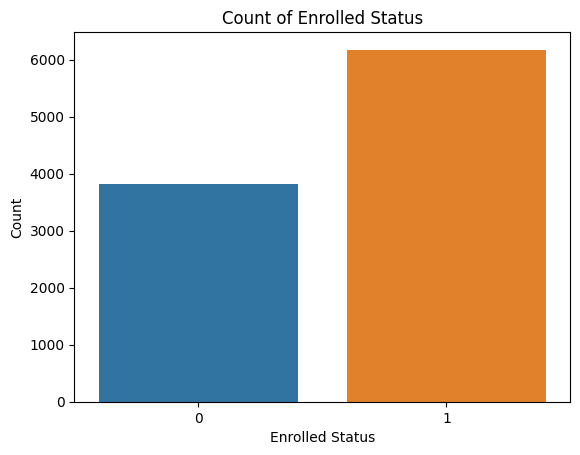

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt


# Create the count chart using Seaborn
sns.countplot(data=train_df, x='enrolled')

# Add labels and title
plt.xlabel('Enrolled Status')
plt.ylabel('Count')
plt.title('Count of Enrolled Status')

# Show the plot
plt.show()

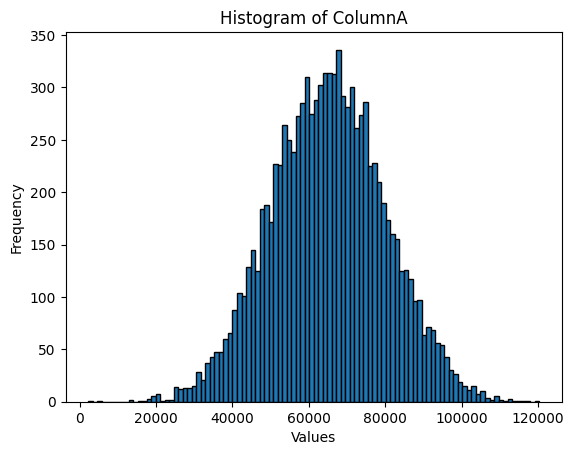

In [20]:
plt.hist(train_df["salary"], bins=100, edgecolor='black')  # Adjust 'bins' as needed

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of ColumnA')

# Show the plot
plt.show()

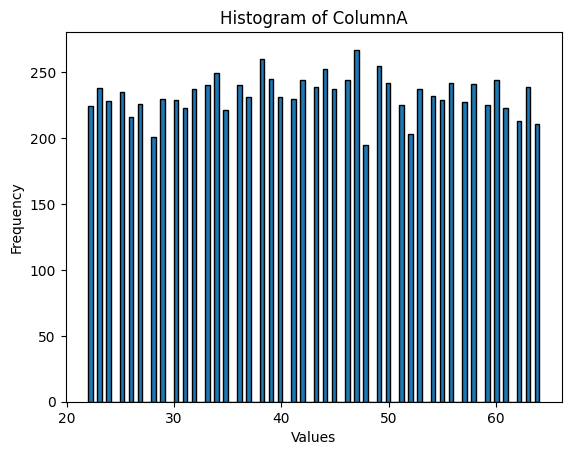

In [21]:
plt.hist(train_df["age"], bins=100, edgecolor='black')  # Adjust 'bins' as needed

# Add labels and title
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of ColumnA')

# Show the plot
plt.show()

# Encoding the object data type columns

In [22]:
transformation_dict = {}
for i in train_df.columns:
    if train_df[i].dtypes!="int64" and train_df[i].dtypes!= "float64":
        #train_df[i]
        value_to_index = {}
        for index, value in enumerate(train_df[i].unique()):
            value_to_index[value] = index
        transformation_dict[i] = value_to_index
with open("label_transformation.json","w") as fp:
    json.dump(transformation_dict,fp)
print(transformation_dict)

{'gender': {'Female': 0, 'Male': 1, 'Other': 2}, 'marital_status': {'Single': 0, 'Divorced': 1, 'Married': 2, 'Widowed': 3}, 'employment_type': {'Part-time': 0, 'Full-time': 1, 'Contract': 2}, 'region': {'West': 0, 'Midwest': 1, 'Northeast': 2, 'South': 3}, 'has_dependents': {'No': 0, 'Yes': 1}}


In [23]:
for i in transformation_dict.keys():
    train_df[i] = train_df[i].map(transformation_dict[i])
train_df

,employee_id,age,gender,marital_status,salary,employment_type,region,has_dependents,tenure_years,enrolled
0,10001,60,0,0,55122.97,0,0,0,1.5,0
1,10002,50,0,0,89549.66,1,0,1,12.8,1
2,10003,36,1,1,74145.66,0,1,0,3.8,0
3,10004,64,0,2,53877.83,1,2,0,3.3,0
4,10005,29,1,0,63404.63,2,1,1,10.0,0
...,...,...,...,...,...,...,...,...,...,...
9995,19996,52,0,2,64551.78,0,3,0,0.5,0
9996,19997,37,1,3,74252.35,1,2,1,1.3,1
9997,19998,52,1,0,60903.60,1,1,1,2.2,1
9998,19999,46,1,2,61982.89,1,1,1,4.5,1


In [24]:
data =train_df.iloc[:,:-1]
target = train_df["enrolled"]

# Hyperparameter Optimization

In [25]:
def objective(trial):
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.4, random_state=42, stratify=target)
    dtrain = xgb.DMatrix(train_x, label=train_y)
    dvalid = xgb.DMatrix(valid_x, label=valid_y)

    param = {
        "verbosity": 0,
        "objective": "binary:hinge",
        "eval_metric":["auc","logloss"],
        # use exact for small dataset.
        "tree_method": "exact",
        # defines booster, gblinear for linear functions.
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        # L2 regularization weight.
        "lambda": trial.suggest_float("lambda", 1e-1, 1.0, log=True),
        # L1 regularization weight.
        "alpha": trial.suggest_float("alpha", 1e-1, 1.0, log=True),
        # sampling ratio for training data.
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        # sampling according to each tree.
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
    }

    if param["booster"] in ["gbtree", "dart"]:
        # maximum depth of the tree, signifies complexity of the tree.
        param["max_depth"] = trial.suggest_int("max_depth", 3, 7, step=1)
        # minimum child weight, larger the term more conservative the tree.
        param["min_child_weight"] = trial.suggest_int("min_child_weight", 2, 5)
        param["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
        # defines how selective algorithm is.
        param["gamma"] = trial.suggest_float("gamma", 1e-1, 1.0, log=True)
        param["grow_policy"] = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])

    if param["booster"] == "dart":
        param["sample_type"] = trial.suggest_categorical("sample_type", ["uniform", "weighted"])
        param["normalize_type"] = trial.suggest_categorical("normalize_type", ["tree", "forest"])
        param["rate_drop"] = trial.suggest_float("rate_drop", 1e-8, 1.0, log=True)
        param["skip_drop"] = trial.suggest_float("skip_drop", 1e-8, 1.0, log=True)

    bst = xgb.train(param, dtrain)
    preds = bst.predict(dvalid)
    pred_labels = np.rint(preds)
    f1 = sklearn.metrics.f1_score(valid_y, pred_labels) 
    
    return f1


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: ", len(study.trials))
    print("Best trial:")
    trial = study.best_trial

    print("Value: {}".format(trial.value))
    print("Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2025-03-26 17:51:04,516] A new study created in memory with name: no-name-742a6f9e-ade7-4900-afac-da1bc91269ff
[I 2025-03-26 17:51:04,601] Trial 0 finished with value: 0.7635239567233385 and parameters: {'booster': 'dart', 'lambda': 0.15036447783703086, 'alpha': 0.42176214721722927, 'subsample': 0.9096666801981546, 'colsample_bytree': 0.7520972181743841, 'max_depth': 7, 'min_child_weight': 3, 'eta': 1.286245553628349e-07, 'gamma': 0.4857541362046144, 'grow_policy': 'depthwise', 'sample_type': 'uniform', 'normalize_type': 'tree', 'rate_drop': 0.0031753077426982046, 'skip_drop': 0.00017091875113186124}. Best is trial 0 with value: 0.7635239567233385.
[I 2025-03-26 17:51:04,634] Trial 1 finished with value: 0.7635239567233385 and parameters: {'booster': 'gblinear', 'lambda': 0.19002212270590949, 'alpha': 0.4686259112169031, 'subsample': 0.5549117843733741, 'colsample_bytree': 0.6650611304221414}. Best is trial 0 with value: 0.7635239567233385.
[I 2025-03-26 17:51:04,690] Trial 2 finish

Number of finished trials:  100
Best trial:
Value: 0.999797529864345
Params: 
    booster: gbtree
    lambda: 0.17311243578509095
    alpha: 0.24013284357387843
    subsample: 0.7075477803761135
    colsample_bytree: 0.9988094278291831
    max_depth: 4
    min_child_weight: 2
    eta: 0.5819198801578864
    gamma: 0.5175674223114789
    grow_policy: lossguide


# Model Training and saving

In [26]:
best_params = trial.params

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.4, random_state=42, stratify=target)


dtrain = xgb.DMatrix(train_data, label=train_target)
dtest = xgb.DMatrix(test_data, label=test_target)

best_params["verbosity"] = 1
bst = xgb.train(best_params, dtrain)

train_preds = bst.predict(dtrain)
train_pred_labels = np.rint(train_preds)

test_preds = bst.predict(dtest)
test_pred_labels = np.rint(test_preds)

print("\n--- Training Set Evaluation ---")
print("F1 Score:", sklearn.metrics.f1_score(train_target, train_pred_labels))
print("Precision:", sklearn.metrics.precision_score(train_target, train_pred_labels))
print("Recall:", sklearn.metrics.recall_score(train_target, train_pred_labels))


print("\n--- Test Set Evaluation ---")
print("F1 Score:", sklearn.metrics.f1_score(test_target, test_pred_labels))
print("Precision:", sklearn.metrics.precision_score(test_target, test_pred_labels))
print("Recall:", sklearn.metrics.recall_score(test_target, test_pred_labels))


model_filename = "best_xgboost_model.bin"
bst.save_model(model_filename)
print(f"\nBest XGBoost model saved as: {model_filename}")


--- Training Set Evaluation ---
F1 Score: 0.9989209603452928
Precision: 0.9981132075471698
Recall: 0.9997300215982722

--- Test Set Evaluation ---
F1 Score: 0.9991906110886281
Precision: 0.9987864077669902
Recall: 0.9995951417004049

Best XGBoost model saved as: best_xgboost_model.bin


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [17:51:13] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
